## ASR Benchmarking for noisy files

In [1]:
# %matplotlib inline

import os

import IPython
import matplotlib
import matplotlib.pyplot as plt
import torch
import torchaudio

matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(torch.__version__)
print(torchaudio.__version__)
print(device)

1.13.1
0.13.1
cpu


### Torchaudio pipelining

- wav2vec for feature extraction
- CTC decoder

In [2]:
# Helper functions
def plot_specgram(waveform: torch.Tensor, sample_rate: float, title="Spectrogram"):
    waveform = waveform.numpy()

    figure, ax = plt.subplots()
    ax.specgram(waveform[0], Fs=sample_rate)
    figure.suptitle(title)
    figure.tight_layout()

def add_noise_ratio(waveform: torch.Tensor, noise_ratio: float = 0.1) -> torch.Tensor:
    """
    Adds a specific ratio of noise to an audio signal.

    Args:
        waveform: The input audio waveform as a PyTorch tensor.
        noise_ratio: The ratio of noise to add to the signal (0.0 to 1.0).

    Returns:
        The noisy audio waveform as a PyTorch tensor.
    """

    noise = torch.randn_like(waveform)
    noisy_waveform = waveform + noise_ratio * noise
    return noisy_waveform

def noise(waveform: torch.Tensor) -> torch.Tensor:
    noise = torch.randn_like(waveform)
    assert noise.shape == waveform.shape, "The generated noise has differet size"
    return noise

In [3]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

print("Sample Rate:", bundle.sample_rate)

print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


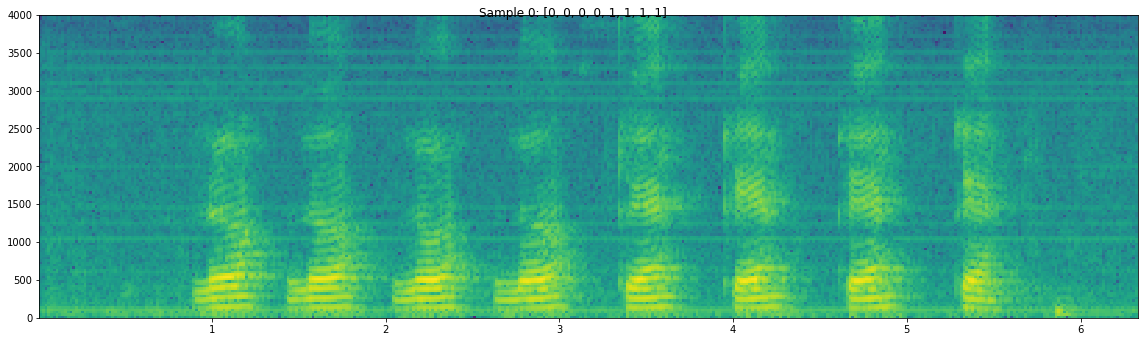

In [4]:
dataset = torchaudio.datasets.YESNO(
    root="./audio",
    download=True
)

sample_index = 0
waveform, sample_rate, label = dataset[sample_index]
plot_specgram(waveform, sample_rate, title=f"Sample {sample_index}: {label}")
IPython.display.Audio(waveform, rate=sample_rate)

In [6]:
model = bundle.get_model().to(device)
print(model.__class__)

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [7]:
# Preprocess the dataset with specific sample rate
waveform, sample_rate, label = dataset[1]

waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)
    
IPython.display.Audio(waveform, rate=sample_rate)

In [ ]:
with torch.inference_mode():
    features, _ = model.extract_features(waveform)